In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import threadpoolctl

## Part II: Airline Safety Records

In this section of the assignment, we analyse the airline safety dataset. The premise of the dataset is about people's reactions to high profile airline accidents - and why they would avoid travelling with certain particular airlines. Hence, we will use the dataset to investigate which airlines are similar based on their past safety records.

The main modelling that we will do here is using K-means clustering. Given that the dataset does not have a target variable, this is an unsupervised learning problem. We will use the K-means algorithm to cluster the airlines based on their safety records. We will then use the clusters to identify which airlines are similar to each other.

**Loading in the Dataset**

In [150]:
# Load the data
airline = pd.read_csv('../datasets/airline-safety.csv')
airline.head(5)

,airline,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
0,Aer Lingus,320906734,2,0,0,0,0,0
1,Aeroflot*,1197672318,76,14,128,6,1,88
2,Aerolineas Argentinas,385803648,6,0,0,1,0,0
3,Aeromexico*,596871813,3,1,64,5,0,0
4,Air Canada,1865253802,2,0,0,2,0,0


The description of the features in the airline data is:
- **airline** - the name of the airline (and regional subsidaries)
- **avail_seat_km_per_week** - the number of available seat kilometers flown by the airline per week
- **incidents_85_99** - the number of incidents that occured between 1985 and 1999
- **fatal_accidents_85_99** - the number of fatal accidents that occured between 1985 and 1999
- **fatalities_85_99** - the total number of fatalities that occured between 1985 and 1999
- **incidents_00_14** - the number of incidents that occured between 2000 and 2014
- **fatal_accidents_00_14** - the number of fatal accidents that occured between 2000 and 2014
- **fatalities_00_14** - the total number of fatalities that occured between 2000 and 2014

We can see that the data is somewhat broken down into 3 components:
- The name of the airline and the number of available seat kilometers flown by the airline per week
- The number of incidents, fatal accidents and fatalities that occured between 1985 and 1999
- The number of incidents, fatal accidents and fatalities that occured between 2000 and 2014

The variables in the second and third components are closely related to each other. For example, the number of incidents that occured between is related to the number of fatal accidents. Therefore, fatal accidents cannot be more than the number of incidents. We might consider just using one of the variables in each component to avoid redundancy. However, we will keep all the variables for now.

In [153]:
airline.head(10)

,airline,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
0,Aer Lingus,320906734,2,0,0,0,0,0
1,Aeroflot*,1197672318,76,14,128,6,1,88
2,Aerolineas Argentinas,385803648,6,0,0,1,0,0
3,Aeromexico*,596871813,3,1,64,5,0,0
4,Air Canada,1865253802,2,0,0,2,0,0
5,Air France,3004002661,14,4,79,6,2,337
6,Air India*,869253552,2,1,329,4,1,158
7,Air New Zealand*,710174817,3,0,0,5,1,7
8,Alaska Airlines*,965346773,5,0,0,5,1,88
9,Alitalia,698012498,7,2,50,4,0,0


Before we analyse the data, we will load in the dataset and do some basic data cleaning. It is good practice once again to check if there are any missing or invalid data in the dataset. 

More importantly, as we have looked at the dataset, we can see that the variable avail_seat_km_per_week is a extremely large in comparison to the other variables. We can either use a different metric to scale down the variable, or perform scaling on the dataset.

In [154]:
# Check for missing values
null_count = np.array(airline.isnull().sum())
na_counts = np.array(airline.isna().sum())
pd.DataFrame(np.vstack((null_count, na_counts)), columns=airline.columns, index=['null_count','na_counts'])

,airline,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
null_count,0,0,0,0,0,0,0,0
na_counts,0,0,0,0,0,0,0,0


Before we perform scaling, there is an important aspect in the data that relates to the feature avail_seat_km_per_week. The feature is a measure of the size of the airline, and obviouly airlines that are bigger will fly more and hence have more incidents. Therefore, we will scale the feature space by the size of the airline and get a meaure of for example incidents per week per km. This will allow us to compare airlines of different sizes on a similar scale.

In [226]:
# Before scaling the data, we need to remove the 'airline' column and store it first
airline_name = airline['airline']
airline_v = airline.drop('airline', axis=1)

# feature space turned into per km
airline_v = airline_v.div(airline_v['avail_seat_km_per_week'], axis=0)
airline_v = airline_v.drop('avail_seat_km_per_week', axis=1)

# Scaling the data using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
airline_scaled = pd.DataFrame(scaler.fit_transform(airline_v), columns=airline_v.columns)

In [227]:
airline_scaled.head(5)

,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
0,-0.152448,-0.779887,-0.681982,-0.886780,-0.557278,-0.390682
1,5.032801,3.113161,-0.120121,0.191619,0.000220,0.052399
2,0.692030,-0.779887,-0.681982,-0.328824,-0.557278,-0.390682
3,-0.261740,-0.221907,-0.118272,0.916466,-0.557278,-0.390682
4,-0.620021,-0.779887,-0.681982,-0.655968,-0.557278,-0.390682


### K-Means Clustering

We want to figure out what is the optimal number of clusters, where optimal in a sense being that the within cluster distances (meausured by Euclidan distances) are minimised. We can determine the k-number of clusters by using a elbow/scree plot. Alternatively, we can also use the silhouette score to determine the optimal number of clusters.

The silhouette score calculates the mean siluhouette coefficient of all samples. 

**1. Finding the optimal number of clusters using k**

In [228]:
# We want to find the best k value for kmeans:
# First we define the range of the k values to test:
k_values = np.arange(2, 11)
scores = []
inertia = []
print('Silhouette Scores for k = 2 to 10:')
for i in k_values:
    kmeans = KMeans(n_clusters=i, random_state=5508, n_init=10)
    kmeans.fit_predict(airline_scaled.values)
    score = silhouette_score(airline_scaled.values, kmeans.labels_)
    scores.append(score)
    inertia.append(kmeans.inertia_)
    print('k = {}, Average Score: {}'.format(i, score))

Silhouette Scores for k = 2 to 10:
k = 2, Average Score: 0.5494544011830644
k = 3, Average Score: 0.5555997936034959
k = 4, Average Score: 0.5444077992085773
k = 5, Average Score: 0.4923890068979615
k = 6, Average Score: 0.30429520880077765
k = 7, Average Score: 0.29979914246459677
k = 8, Average Score: 0.3169814411566127
k = 9, Average Score: 0.3405946165524244
k = 10, Average Score: 0.34608830580246597


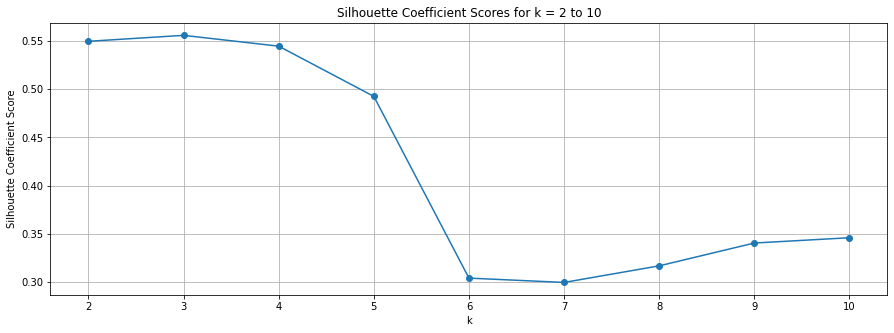

In [229]:
# Plot the silhouette coefficient socres for each k value
plt.figure(figsize=(15, 5))
plt.plot(k_values, scores, marker='o')
plt.title('Silhouette Coefficient Scores for k = 2 to 10')
plt.xlabel('k')
plt.ylabel('Silhouette Coefficient Score')
plt.grid()

Looking at the silhouette score, we can see that the optimal number of clusters is 3. We want to affirm our understanding of the number of k-clusters. Therefore, we might want to look at the elbow plot as well.

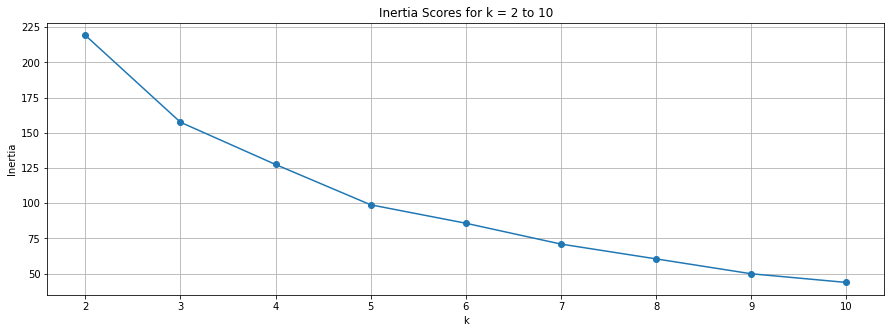

In [230]:
# Evaluate the best k value using the elbow method
plt.figure(figsize=(15, 5))
plt.plot(k_values, inertia, marker='o')
plt.title('Inertia Scores for k = 2 to 10')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.grid()

Unfortunately, the inertia elbow plot does not provide us much information about which k to choose as the optimal number of clusters. We can see that the inertia decreases as the number of clusters increases, which is to be expected. However, we also do not observe an "elbow" or an inflection point in the plot. Hence, we use the infomation from the silhouette score to determine the optimal number of clusters. 

**2. Using k=3 for K-Means Clustering**

In the part above, we chose k=3 to be the optimal number of clusters for our dataset. We want to run the k-Means clustering again and try to interpret the results of the clusters

In [231]:
k3 = KMeans(n_clusters=3, random_state=5508, n_init=10)
k3.fit_predict(airline_scaled.values)

array([2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2,
       1, 2, 1, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 1, 1, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

Given that we are in a 6-dimensional feature space, it might be difficult to visualise the clusters. One alternative is to use a pairwise scatter plot to visualise the clusters. However, we might be better able to understand and interpret the groups in terms of the features if we use a parallel coordinates plot. Another way is to just look at the values of the cluster centroids.

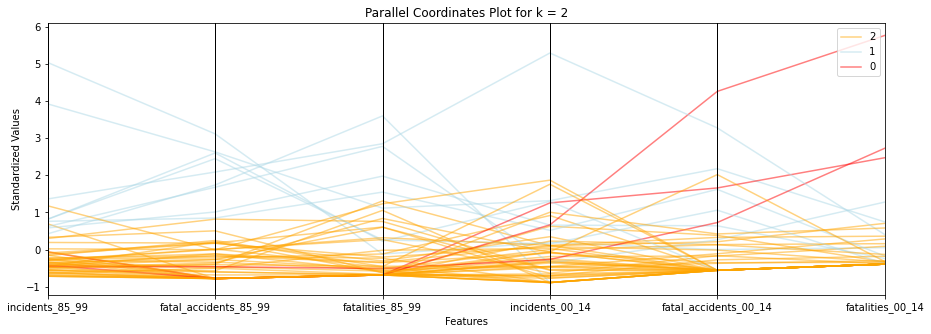

In [232]:
# Parallel Coordinates Plot
from pandas.plotting import parallel_coordinates
features = airline_scaled.columns
airline_scaled['cluster'] = k3.labels_

plt.figure(figsize=(15, 5))
parallel_coordinates(airline_scaled, 'cluster', color=['orange', 'lightblue', 'red'], alpha=0.5)
plt.title('Parallel Coordinates Plot for k = 2')
plt.xlabel('Features')
plt.ylabel('Standardized Values')
plt.grid()


We can observe that the instances in cluster 0 and cluster 1 are different from each other, where the instances that are in cluster 1 tend to have generally higher values for all the features. However, the instances in cluster 0 and cluster 2 are more similar to each other. However, there is a telling sign that the instances in cluster 2 have a higher number of incidents and fatal accidents between 2000 and 2014, which are more recent. This might indicate that the instances in cluster 0 are airlines that are more unsafe. We want to see which airlines belongs in this cluster.

In [234]:
# Identifying which are the airlines in each cluster
airline_scaled['airline'] = airline_name
airline_scaled[airline_scaled['cluster'] == 0]

,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14,cluster,airline
25,-0.416519,-0.779887,-0.681982,1.255979,1.658199,2.470600,0,Gulf Air
29,-0.063912,-0.779887,-0.681982,0.665130,4.256451,5.761024,0,Kenya Airways
34,-0.455587,-0.459399,-0.509974,-0.265338,0.727784,2.725522,0,Malaysia Airlines


In [235]:
# Looking at the cluster centroids
centers = pd.DataFrame(k3.cluster_centers_, columns=features)
centers

,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
0,-0.312006,-0.673058,-0.624646,0.551923,2.214145,3.652382
1,1.592825,2.016455,1.580292,0.908835,0.879851,0.101005
2,-0.304532,-0.366566,-0.280652,-0.223529,-0.330934,-0.269686


By looking at the cluster centroids in the feature space, we can conclude that the instances in cluster 0 have significantly higher centers as compared to the other 2 clusters. The instances in cluster 1, we would consider them to be moderately unsafe as there cluster centers are were higher in the past, but has tapered off in recent years. Airlines in cluster 0 we would consider them to be the safest.

**3. Explain decision on scaling the data and using a scaled by km factor**

To do tomorrow

**4. Perfom a K-means cluster analysis with the k=3**

We now subset the K-means cluster analysis for the 2 time components, and see if there are any differences in the clusters.